<a href="https://colab.research.google.com/github/Disha-Sikka/SAR-to-EO-CycleGAN/blob/main/cycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Copying Extracted files in Colab's Local Disk

In [2]:
import shutil
import os

# --- IMPORTANT: ADJUST THESE PATHS to the exact location of your extracted subset folders in Google Drive ---
# Example: If your 'winter_s1' and 'winter_s2' folders are directly inside 'My Drive/CycleGAN/'
source_drive_winter_s1_folder = '/content/drive/MyDrive/CycleGAN/winter_s1'
source_drive_winter_s2_folder = '/content/drive/MyDrive/CycleGAN/winter_s2'
# ------------------------------------------------------------------------------------------------------------

# Define the base destination path on Colab's local disk for your subset
# This will be the DATA_ROOT_DIR for your Config class later
destination_colab_data_root = '/content/my_sen12ms_data_subset' # A clear name for the subset root folder

# Create the base destination folder in Colab's local disk
os.makedirs(destination_colab_data_root, exist_ok=True)

# Define specific destination paths for winter_s1 and winter_s2 folders within the subset root
dest_s1_folder = os.path.join(destination_colab_data_root, 'winter_s1')
dest_s2_folder = os.path.join(destination_colab_data_root, 'winter_s2')

# Remove existing folders if they exist, to ensure a clean copy and avoid errors
if os.path.exists(dest_s1_folder):
    print(f"Removing existing folder: {dest_s1_folder}...")
    shutil.rmtree(dest_s1_folder)
if os.path.exists(dest_s2_folder):
    print(f"Removing existing folder: {dest_s2_folder}...")
    shutil.rmtree(dest_s2_folder)

print(f"Copying winter_s1 from Drive to Colab local disk: {dest_s1_folder}...")
try:
    if os.path.exists(source_drive_winter_s1_folder):
        shutil.copytree(source_drive_winter_s1_folder, dest_s1_folder)
        print("winter_s1 folder copied successfully.")
    else:
        print(f"Error: Source folder not found at {source_drive_winter_s1_folder}. Please check the path in your Google Drive.")

    print(f"Copying winter_s2 from Drive to Colab local disk: {dest_s2_folder}...")
    if os.path.exists(source_drive_winter_s2_folder):
        shutil.copytree(source_drive_winter_s2_folder, dest_s2_folder)
        print("winter_s2 folder copied successfully.")
    else:
        print(f"Error: Source folder not found at {source_drive_winter_s2_folder}. Please check the path in your Google Drive.")

except Exception as e:
    print(f"An error occurred during copying: {e}")

print("Copying complete.")

Removing existing folder: /content/my_sen12ms_data_subset/winter_s1...
Removing existing folder: /content/my_sen12ms_data_subset/winter_s2...
Copying winter_s1 from Drive to Colab local disk: /content/my_sen12ms_data_subset/winter_s1...
winter_s1 folder copied successfully.
Copying winter_s2 from Drive to Colab local disk: /content/my_sen12ms_data_subset/winter_s2...
winter_s2 folder copied successfully.
Copying complete.


# Importing Libraries

In [3]:
!pip install rasterio
import os
import glob
import random
import numpy as np
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import matplotlib.pyplot as plt # NEW: For displaying images
from IPython.display import Image as DisplayImage, display # NEW: For displaying saved images

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import rasterio


# Configuration

- For defining the parameters. So, that we can easily change them when we want.

In [4]:
class Config:
    """
    Configuration class for the CycleGAN project.
    Adjust these parameters based on your system and dataset.
    """
    # Data paths
    # This should be the path to the directory that CONTAINS your 'winter_s1' and 'winter_s2' folders.
    DATA_ROOT_DIR = '/content/my_sen12ms_data_subset'
    SAR_DIR_NAME = 'winter_s1'
    EO_DIR_NAME = 'winter_s2'

    # Model parameters
    INPUT_NC = 3 # Number of input channels for SAR (Set to 3 to match loaded data, even if original is 2)
    NGF = 64 # Number of generator filters in the first conv layer
    NDF = 64 # Number of discriminator filters in the first conv layer
    N_RESNET_BLOCKS = 6 # Number of ResNet blocks in the generator

    # Training parameters
    BATCH_SIZE = 1 # CycleGAN typically uses batch size 1
    NUM_EPOCHS = 200 # Increased for final project
    LR = 0.0002 # Learning rate
    LR_DECAY_EPOCH = 100 # Epoch at which learning rate starts to linearly decay to 0
    BETA1 = 0.5 # Adam optimizer beta1
    LAMBDA_CYCLE = 10.0 # Weight for cycle consistency loss
    LAMBDA_IDENTITY = 5.0 # Weight for identity mapping loss (optional, but helps stabilize)

    # Image parameters
    IMAGE_SIZE = 256 # All images will be resized to this (e.g., 256x256)
    NUM_WORKERS = 4 # Number of data loading workers (adjust based on CPU cores, 0 for debugging)

    # Output and logging
    # Save outputs and checkpoints to Google Drive for persistence across sessions
    OUTPUT_BASE_DIR = '/content/drive/MyDrive/CycleGAN/SAR_EO_Project_Outputs' # Base directory in Drive
    OUTPUT_DIR = os.path.join(OUTPUT_BASE_DIR, 'output_cyclegan') # Specific output for images
    CHECKPOINT_DIR = os.path.join(OUTPUT_BASE_DIR, 'checkpoints_cyclegan') # Specific output for models

    SAVE_EPOCH_FREQ = 5 # Save model checkpoints every N epochs
    PRINT_FREQ = 10 # Print training loss every N batches

    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Load Checkpoints (if resuming training)

    # EO Band Configurations (Sentinel-2 bands)
    # B1 (Coastal Aerosol), B2 (Blue), B3 (Green), B4 (Red), B5 (Red Edge 1),
    # B6 (Red Edge 2), B7 (Red Edge 3), B8 (NIR), B8A (NIR Narrow), B9 (Water Vapour),
    # B10 (SWIR - Cirrus), B11 (SWIR 1), B12 (SWIR 2)
    EO_BAND_CONFIGS = {
        "RGB": [4, 3, 2], # B4, B3, B2 (Red, Green, Blue) - This will work best with your 3-channel EO data
        "NIR_SWIR_RedEdge": [8, 11, 5], # B8, B11, B5 (NIR, SWIR1, Red Edge 1) - Will be zero-filled for missing bands
        "RGB_NIR": [4, 3, 2, 8] # B4, B3, B2, B8 (Red, Green, Blue, NIR) - NIR will be zero-filled
    }
    # Choose which configuration to train for the final project.
    # Keep as RGB for best results with current data.
    CURRENT_EO_CONFIG_NAME = "RGB"
    OUTPUT_NC = 3


# Initialize configuration
config = Config()

# Create output directories if they don't exist in Google Drive
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)
start_epoch = 9 # Keep this line for initial run, but change if resuming
# Example: To resume from epoch 50, set start_epoch = 50 and ensure checkpoints exist
# If you want to resume, uncomment and adjust the path
try:
    checkpoint_path_G_A = os.path.join(config.CHECKPOINT_DIR, f'G_A_epoch_{start_epoch}.pth')
    checkpoint_path_G_B = os.path.join(config.CHECKPOINT_DIR, f'G_B_epoch_{start_epoch}.pth')
    checkpoint_path_D_A = os.path.join(config.CHECKPOINT_DIR, f'D_A_epoch_{start_epoch}.pth')
    checkpoint_path_D_B = os.path.join(config.CHECKPOINT_DIR, f'D_B_epoch_{start_epoch}.pth')

    if os.path.exists(checkpoint_path_G_A):
        G_A.load_state_dict(torch.load(checkpoint_path_G_A, map_location=config.DEVICE))
        G_B.load_state_dict(torch.load(checkpoint_path_G_B, map_location=config.DEVICE))
        D_A.load_state_dict(torch.load(checkpoint_path_D_A, map_location=config.DEVICE))
        D_B.load_state_dict(torch.load(checkpoint_path_D_B, map_location=config.DEVICE))
        print(f"Resuming training from epoch {start_epoch}")
    else:
        print("No checkpoints found, starting training from scratch.")
except Exception as e:
    print(f"Error loading checkpoints: {e}. Starting training from scratch.")
    start_epoch = 0


No checkpoints found, starting training from scratch.


# DataLoader and Preprocessing Custom Class


In [5]:
class Sen12MSDataset(Dataset):
    """
    Custom Dataset for Sen12MS SAR and EO images.
    Expects SAR images in `root_dir/SAR_DIR_NAME` and EO images in `root_dir/EO_DIR_NAME`.
    Each directory should contain subfolders for different regions/image pairs.
    """
    def __init__(self, root_dir, sar_dir_name, eo_dir_name, eo_bands, image_size=256):
        self.sar_root = os.path.join(root_dir, sar_dir_name)
        self.eo_root = os.path.join(root_dir, eo_dir_name)
        self.eo_bands = eo_bands # List of band numbers (e.g., [4, 3, 2]) from Config
        self.image_size = image_size

        # Find all .tif files within the SAR root, recursively
        self.sar_image_paths = sorted(glob.glob(os.path.join(self.sar_root, '**', '*.tif'), recursive=True))

        # Find all .tif files within the EO root, recursively (assuming 3-channel RGB .tif files)
        self.eo_image_paths = sorted(glob.glob(os.path.join(self.eo_root, '**', '*.tif'), recursive=True))

        # Filter out unreadable/problematic files during initialization using rasterio
        self.sar_image_paths = self._filter_unreadable_images(self.sar_image_paths, "SAR")
        self.eo_image_paths = self._filter_unreadable_images(self.eo_image_paths, "EO")

        self.pairs = self._match_sar_eo_pairs()

        # Define transform for Resize only. ToPILImage and ToTensor will be applied manually.
        # This transform is applied after initial tensor creation from numpy
        self.resize_transform = transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BICUBIC)

        print(f"Found {len(self.pairs)} matched SAR-EO pairs.")
        if len(self.pairs) == 0:
            print("WARNING: No SAR-EO pairs found. Please check your data paths and extraction, or if all images are unreadable.")
            print(f"SAR root: {self.sar_root}")
            print(f"EO root: {self.eo_root}")
            print(f"Example SAR path search: {os.path.join(self.sar_root, '**', '*.tif')}")
            print(f"Example EO path search: {os.path.join(self.eo_root, '**', '*.tif')}")

    def _filter_unreadable_images(self, image_paths, image_type="Image"):
        """
        Checks if images are readable by rasterio and filters out unreadable ones.
        """
        readable_paths = []
        for path in tqdm(image_paths, desc=f"Checking {image_type} readability"):
            try:
                with rasterio.open(path) as src:
                    _ = src.read(1) # Try to read a band to ensure it's truly readable
                readable_paths.append(path)
            except Exception as e: # Catch broader exceptions for rasterio issues
                print(f"Skipping unreadable {image_type} file: {path} (Error: {e})")
        return readable_paths

    def _match_sar_eo_pairs(self):
        """
        Creates pseudo-pairs for unpaired training. Each SAR image is paired with a random EO image.
        This ensures the dataset has a non-zero length and provides data for training.
        """
        if not self.sar_image_paths or not self.eo_image_paths:
            return [] # No data found

        matched_pairs = []
        for sar_path in self.sar_image_paths:
            random_eo_path = random.choice(self.eo_image_paths)
            matched_pairs.append((sar_path, random_eo_path))

        return matched_pairs


    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        sar_path, eo_path = self.pairs[idx]

        # --- Load and Preprocess SAR Image ---
        with rasterio.open(sar_path) as src:
            sar_image_np_raw = src.read().astype(np.float32) # Reads (C, H, W) directly

        # --- Robust SAR Channel Handling ---
        # Ensure sar_image_np has exactly config.INPUT_NC channels (which is 3)
        if sar_image_np_raw.shape[0] == config.INPUT_NC:
            sar_image_np = sar_image_np_raw # Perfect match
        elif sar_image_np_raw.shape[0] == 1 and config.INPUT_NC == 3:
            # If 1-channel, but 3 expected, repeat it (e.g., VV -> VV,VV,VV)
            sar_image_np = np.repeat(sar_image_np_raw, 3, axis=0)
            # print(f"DEBUG: SAR 1-channel -> 3-channel repeat for {os.path.basename(sar_path)}")
        elif sar_image_np_raw.shape[0] == 2 and config.INPUT_NC == 3:
            # If 2-channel, but 3 expected, pad with zeros (e.g., VV,VH -> VV,VH,0)
            sar_image_np = np.pad(sar_image_np_raw, ((0, 1), (0,0), (0,0)), mode='constant')
            # print(f"DEBUG: SAR 2-channel -> 3-channel pad for {os.path.basename(sar_path)}")
        elif sar_image_np_raw.shape[0] > config.INPUT_NC:
            # If more channels than expected, take the first INPUT_NC channels
            sar_image_np = sar_image_np_raw[:config.INPUT_NC, :, :]
            # print(f"DEBUG: SAR >{config.INPUT_NC} channels -> {config.INPUT_NC}-channel truncate for {os.path.basename(sar_path)}")
        else: # sar_image_np_raw.shape[0] < config.INPUT_NC (e.g., 1 channel, expecting 3, but not handled by repeat logic)
            # Pad with zeros if fewer channels than expected
            padding_needed = config.INPUT_NC - sar_image_np_raw.shape[0]
            sar_image_np = np.pad(sar_image_np_raw, ((0, padding_needed), (0,0), (0,0)), mode='constant')
            # print(f"DEBUG: SAR <{config.INPUT_NC} channels -> {config.INPUT_NC}-channel pad for {os.path.basename(sar_path)}")

        # Final sanity check (should ideally not be hit)
        if sar_image_np.shape[0] != config.INPUT_NC:
            print(f"CRITICAL ERROR: SAR image {os.path.basename(sar_path)} has {sar_image_np.shape[0]} channels after processing, but {config.INPUT_NC} expected. Returning zero tensor.")
            return torch.zeros(config.INPUT_NC, self.image_size, self.image_size).float(), \
                   torch.zeros(config.OUTPUT_NC, self.image_size, self.image_size).float()

        sar_image_tensor = torch.from_numpy(sar_image_np).float()
        sar_image_tensor = torch.nan_to_num(sar_image_tensor, nan=0.0, posinf=0.0, neginf=0.0)

        # Resize directly on tensor using F.interpolate.
        sar_image_tensor = F.interpolate(sar_image_tensor.unsqueeze(0), size=(self.image_size, self.image_size), mode='bicubic', align_corners=False).squeeze(0)

        # Normalize SAR to [-1, 1]
        sar_min = sar_image_tensor.min()
        sar_max = sar_image_tensor.max()
        if sar_max > sar_min:
            sar_image_tensor = (sar_image_tensor - sar_min) / (sar_max - sar_min) # Scale to [0, 1]
        else:
            sar_image_tensor = torch.zeros_like(sar_image_tensor)
        sar_image_tensor = sar_image_tensor * 2.0 - 1.0 # Scale to [-1, 1]


        # --- Load and Preprocess EO Image ---
        with rasterio.open(eo_path) as src:
            eo_image_np = src.read().astype(np.float32) # Read all bands, convert to float32

        eo_image_tensor_full = torch.from_numpy(eo_image_np).float()

        # Select specific EO bands from the multi-channel image
        # Based on your QGIS screenshot, EO is 3-channel: Red (B4), Green (B3), Blue (B2)
        # So, Channel 0 = B4, Channel 1 = B3, Channel 2 = B2
        band_number_to_channel_index = {
            1: 0,   # Coastal Aerosol
            2: 1,   # Blue
            3: 2,   # Green
            4: 3,   # Red
            5: 4,   # Red Edge 1
            6: 5,   # Red Edge 2
            7: 6,   # Red Edge 3
            8: 7,   # NIR
            '8A': 8,  # NIR Narrow (often band 8A is at index 8)
            9: 9,   # Water Vapour
            10: 10, # SWIR - Cirrus
            11: 11, # SWIR 1
            12: 12  # SWIR 2
        }

        selected_eo_bands_tensors = []
        for band_num in self.eo_bands: # Iterate through desired band numbers from Config (e.g., 4, 3, 2)
            channel_idx = band_number_to_channel_index.get(band_num, -1)

            if channel_idx == -1 or channel_idx >= eo_image_tensor_full.shape[0]:
                # Print warning only if the band is explicitly requested but not found/out of range
                if band_num in config.EO_BAND_CONFIGS[config.CURRENT_EO_CONFIG_NAME]:
                    print(f"Warning: Desired band B{band_num} not found or index out of range in EO image {os.path.basename(eo_path)}. Filling with zeros.")
                selected_eo_bands_tensors.append(torch.zeros(1, eo_image_tensor_full.shape[1], eo_image_tensor_full.shape[2], device=config.DEVICE))
            else:
                selected_eo_bands_tensors.append(eo_image_tensor_full[channel_idx:channel_idx+1, :, :])

        if not selected_eo_bands_tensors:
            print(f"Error: No valid bands selected for EO image {os.path.basename(eo_path)}. Returning zeros.")
            eo_image_tensor = torch.zeros(config.OUTPUT_NC, self.image_size, self.image_size, device=config.DEVICE)
        else:
            eo_image_tensor = torch.cat(selected_eo_bands_tensors, dim=0)

        # Ensure the final EO tensor has the correct number of channels (OUTPUT_NC)
        if eo_image_tensor.shape[0] != config.OUTPUT_NC:
            print(f"Error: Final EO tensor has {eo_image_tensor.shape[0]} channels, but expected {config.OUTPUT_NC}. This indicates an issue with band selection or config.OUTPUT_NC.")
            if eo_image_tensor.shape[0] < config.OUTPUT_NC:
                padding_needed = config.OUTPUT_NC - eo_image_tensor.shape[0]
                eo_image_tensor = torch.cat([eo_image_tensor, torch.zeros(padding_needed, eo_image_tensor.shape[1], eo_image_tensor.shape[2], device=config.DEVICE)], dim=0)
            else:
                eo_image_tensor = eo_image_tensor[:config.OUTPUT_NC, :, :]


        # Normalize EO to [-1, 1]
        eo_max_val = 10000.0
        eo_image_tensor = torch.clamp(eo_image_tensor, 0, eo_max_val)
        eo_image_tensor = (eo_image_tensor / eo_max_val) * 2.0 - 1.0

        # Resize directly on tensor using F.interpolate.
        eo_image_tensor = F.interpolate(eo_image_tensor.unsqueeze(0), size=(self.image_size, self.image_size), mode='bicubic', align_corners=False).squeeze(0)

        return sar_image_tensor, eo_image_tensor


In [6]:

# Helper function for Convolutional Block
def conv_block(in_channels, out_channels, kernel_size, stride, padding, use_bias=False, norm_layer=nn.InstanceNorm2d, activation=nn.ReLU(True)):
    """A convolutional block with Conv2d, Normalization, and Activation."""
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=use_bias)
    ]
    if norm_layer:
        layers.append(norm_layer(out_channels))
    if activation:
        layers.append(activation)
    return nn.Sequential(*layers)

# Helper function for Transposed Convolutional Block (for upsampling)
def deconv_block(in_channels, out_channels, kernel_size, stride, padding, output_padding, use_bias=False, norm_layer=nn.InstanceNorm2d, activation=nn.ReLU(True)):
    """A transposed convolutional block with ConvTranspose2d, Normalization, and Activation."""
    layers = [
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding, bias=use_bias)
    ]
    if norm_layer:
        layers.append(norm_layer(out_channels))
    if activation:
        layers.append(activation)
    return nn.Sequential(*layers)


class ResnetBlock(nn.Module):
    def __init__(self, dim, norm_layer=nn.InstanceNorm2d, use_bias=False):
        super(ResnetBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            conv_block(dim, dim, kernel_size=3, stride=1, padding=0, use_bias=use_bias, norm_layer=norm_layer),
            nn.Dropout(0.5), # Added dropout for regularization
            nn.ReflectionPad2d(1),
            conv_block(dim, dim, kernel_size=3, stride=1, padding=0, use_bias=use_bias, norm_layer=norm_layer, activation=None) # No activation after second conv
        )

    def forward(self, x):
        return x + self.conv_block(x)


class Generator(nn.Module):
    """
    Generator model (U-Net based).
    Translates images from domain A to domain B.
    """
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=9, norm_layer=nn.InstanceNorm2d):
        super(Generator, self).__init__()
        use_bias = norm_layer == nn.InstanceNorm2d

        model = [
            nn.ReflectionPad2d(3),
            conv_block(input_nc, ngf, kernel_size=7, stride=1, padding=0, use_bias=use_bias, norm_layer=norm_layer)
        ]

        # Downsampling
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [
                conv_block(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, use_bias=use_bias, norm_layer=norm_layer)
            ]

        # ResNet blocks
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, norm_layer=norm_layer, use_bias=use_bias)]

        # Upsampling
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [
                deconv_block(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1, use_bias=use_bias, norm_layer=norm_layer)
            ]

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0),
            nn.Tanh() # Output activation to map to [-1, 1]
        ]
        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)


class Discriminator(nn.Module):
    """
    Discriminator model (PatchGAN based).
    Classifies image patches as real or fake.
    """
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.InstanceNorm2d):
        super(Discriminator, self).__init__()
        use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4 # Kernel width/height
        padw = 1 # Padding

        model = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        for i in range(1, n_layers):
            mult = 2 ** i
            model += [
                conv_block(ndf * mult // 2, ndf * mult, kernel_size=kw, stride=2, padding=padw, use_bias=use_bias, norm_layer=norm_layer, activation=nn.LeakyReLU(0.2, True))
            ]

        mult = 2 ** n_layers
        model += [
            conv_block(ndf * mult // 2, ndf * mult, kernel_size=kw, stride=1, padding=padw, use_bias=use_bias, norm_layer=norm_layer, activation=nn.LeakyReLU(0.2, True))
        ]

        model += [
            nn.Conv2d(ndf * mult, 1, kernel_size=kw, stride=1, padding=padw) # Output 1-channel prediction map
        ]
        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)



# Class Generator
- U-Net Based
- Translates images from Domain A to Domain B
- In this first we downsample the image, than pass the image through ResNet Block, than we decode the image by upscaling it and adding a conv layer which converts it to RGB format.

# Discriminator Class

- PatchGAN based
- Classifies whether the provided image is real or fake
- Convulational layer and Normalization while downscaling.
- At last layer, Conv layer and Sigmoid

# Adversarial Loss Function

- It tells how well discriminator is working in distinguishing real and fake.
- It also tells how well generator is working in translating the image from one domain to other domain.


In [7]:
class GANLoss(nn.Module):
    """
    Adversarial Loss calculation of discriminator and generator functions. Loss Calculated using mean square
    """
    def __init__(self, gan_mode='mse', target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan': # Least Squares GAN
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla': # Standard GAN (Binary Cross Entropy)
            self.loss = nn.BCEWithLogitsLoss()
        else:
            raise NotImplementedError(f'GAN mode {gan_mode} not implemented.')

    def get_target_tensor(self, prediction, target_is_real):
        """Creates label tensors with the same size as the input prediction."""
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        target_tensor = self.get_target_tensor(prediction, target_is_real)
        return self.loss(prediction, target_tensor)


class CycleConsistencyLoss(nn.Module):
    """
    L1 loss for cycle consistency.
    """
    def __init__(self, lambda_cycle=10.0): # higher the lambda--> higher is the consistency of cycle
        super(CycleConsistencyLoss, self).__init__()
        self.lambda_cycle = lambda_cycle
        self.loss = nn.L1Loss() # because it encourages pixel-wise accuracy

    def forward(self, real_image, cycled_image):
        return self.loss(real_image, cycled_image) * self.lambda_cycle


class IdentityLoss(nn.Module):
    """
    L1 loss for identity mapping.
    Encourages generators to preserve color composition when input is already from the target domain.
    """
    def __init__(self, lambda_identity=5.0):
        super(IdentityLoss, self).__init__()
        self.lambda_identity = lambda_identity
        self.loss = nn.L1Loss()

    def forward(self, real_image, identity_image):
        return self.loss(real_image, identity_image) * self.lambda_identity


# Cycle Consistency Loss

- It calculates the loss while translating SAR to EO and than back to SAR
- Mean Absolute Error

# Identity Loss

- Optional
- Done for colour preservation
- And training Stability


# Utilities for Postprocessing and Metrics

- To convert pixels value from the range [-1,1] to [0,1] or [0,255]
- For showing the images SAR and generated EO side by side.
- To measure the similarity between two images.
- To calculate peak-signal-to-noise (PSNR) ratio.
- To calculate NDVI from EO image

In [8]:
def denormalize_image(tensor):
    """
    Denormalizes a tensor from [-1, 1] to [0, 1].
    """
    return (tensor + 1) / 2.0

def save_combined_image(sar_img, gen_eo_img, real_eo_img, filename):
    """
    Combines Real SAR, Generated EO, and Real EO images side-by-side and saves them.
    Assumes inputs are already denormalized to [0, 1].
    """
    if sar_img.shape[1] == 2: # Check channel dimension (N, C, H, W)
        sar_img_display = sar_img.mean(dim=1, keepdim=True).repeat(1, 3, 1, 1) # Convert to grayscale 3-channel
    else:
        sar_img_display = sar_img.repeat(1, 3, 1, 1) if sar_img.shape[1] == 1 else sar_img

    # For EO, if it has 4 channels (RGB+NIR), select RGB for display
    if gen_eo_img.shape[1] == 4:
        gen_eo_img_display = gen_eo_img[:, :3, :, :] # Take first 3 channels (RGB)
        real_eo_img_display = real_eo_img[:, :3, :, :]
    else:
        gen_eo_img_display = gen_eo_img
        real_eo_img_display = real_eo_img

    # Concatenate images horizontally
    combined_image = torch.cat([sar_img_display, gen_eo_img_display, real_eo_img_display], dim=3) # Concatenate along width
    vutils.save_image(combined_image, filename, normalize=True, nrow=1)

def calculate_ssim(img1, img2, data_range=1.0): # Removed multichannel parameter
    """
    Calculates SSIM between two images.
    """
    # Ensure inputs are (H, W) for grayscale or (H, W, C) for multichannel
    # Squeeze batch dimension if present, move to CPU, convert to numpy
    img1_np = img1.squeeze().cpu().numpy()
    img2_np = img2.squeeze().cpu().numpy()

    _multichannel = False
    _channel_axis = None

    if img1_np.ndim == 3: # If it has 3 dimensions (C, H, W) or (H, W, C)
        if img1_np.shape[0] in [1, 3, 4]: # Common channel counts for C,H,W
            # Assume (C, H, W) and transpose to (H, W, C)
            img1_np = np.transpose(img1_np, (1, 2, 0))
            img2_np = np.transpose(img2_np, (1, 2, 0))
            if img1_np.shape[2] > 1: # If more than 1 channel after transpose
                _multichannel = True
                _channel_axis = -1 # Channels are now the last dimension
        elif img1_np.shape[2] in [1, 3, 4]: # Assume (H, W, C)
            if img1_np.shape[2] > 1:
                _multichannel = True
                _channel_axis = -1
        # If it's 3D but not a common image shape, treat as grayscale (H,W,1)
        elif img1_np.shape[0] > 1 and img1_np.shape[1] > 1 and img1_np.shape[2] == 1: # (H, W, 1)
             _multichannel = False
    elif img1_np.ndim == 2: # Grayscale (H, W)
        _multichannel = False

    # Use channel_axis for multichannel images
    if _multichannel:
        return ssim(im1=img1_np, im2=img2_np, data_range=data_range, channel_axis=_channel_axis)
    else:
        return ssim(im1=img1_np, im2=img2_np, data_range=data_range)

def calculate_psnr(img1, img2, data_range=1.0):
    """
    Calculates PSNR between two images.
    """
    # Ensure inputs are (H, W) for grayscale or (H, W, C) for multichannel
    # Squeeze batch dimension if present, move to CPU, convert to numpy
    img1_np = img1.squeeze().cpu().numpy()
    img2_np = img2.squeeze().cpu().numpy()

    # If it's 3D (C, H, W), transpose to (H, W, C) for consistency (though PSNR doesn't strictly need it)
    if img1_np.ndim == 3 and img1_np.shape[0] in [1, 3, 4]:
        img1_np = np.transpose(img1_np, (1, 2, 0))
        img2_np = np.transpose(img2_np, (1, 2, 0))
    # If it's (H, W, 1), remove the last dim for grayscale PSNR
    elif img1_np.ndim == 3 and img1_np.shape[2] == 1:
        img1_np = img1_np[:, :, 0]
        img2_np = img2_np[:, :, 0]

    return psnr(img1_np, img2_np, data_range=data_range) # Corrected: Positional arguments

def calculate_ndvi(eo_image_tensor, eo_band_config):
    """
    Calculates Normalized Difference Vegetation Index (NDVI) from an EO image tensor.
    """
    try:
        nir_idx = eo_band_config.index(8)
        red_idx = eo_band_config.index(4)
    except ValueError:
        print("Warning: NIR (B8) or Red (B4) band not found in current EO configuration. Cannot calculate NDVI.")
        return None

    if nir_idx >= eo_image_tensor.shape[0] or red_idx >= eo_image_tensor.shape[0]:
        print(f"Warning: NDVI band indices ({nir_idx}, {red_idx}) out of range for tensor with {eo_image_tensor.shape[0]} channels.")
        return None

    nir_band = eo_image_tensor[nir_idx, :, :]
    red_band = eo_image_tensor[red_idx, :, :]

    denominator = nir_band + red_band
    epsilon = 1e-6
    ndvi = (nir_band - red_band) / (denominator + epsilon)

    return ndvi.unsqueeze(0)


# Training Funtion

In [9]:
def train_cyclegan():
    """
    Main function to design and train the CycleGAN model.
    """
    print(f"Using device: {config.DEVICE}")
    print(f"Current EO Output Configuration: {config.CURRENT_EO_CONFIG_NAME} (Bands: {config.EO_BAND_CONFIGS[config.CURRENT_EO_CONFIG_NAME]})")
    print(f"Input Channels (SAR): {config.INPUT_NC}")
    print(f"Output Channels (EO): {config.OUTPUT_NC}")

    # Initialize Dataset and DataLoader
    dataset = Sen12MSDataset(
        root_dir=config.DATA_ROOT_DIR,
        sar_dir_name=config.SAR_DIR_NAME,
        eo_dir_name=config.EO_DIR_NAME,
        eo_bands=config.EO_BAND_CONFIGS[config.CURRENT_EO_CONFIG_NAME],
        image_size=config.IMAGE_SIZE
    )
    dataloader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS)

    # Initialize Generators and Discriminators
    G_A = Generator(config.INPUT_NC, config.OUTPUT_NC, config.NGF, config.N_RESNET_BLOCKS).to(config.DEVICE)
    G_B = Generator(config.OUTPUT_NC, config.INPUT_NC, config.NGF, config.N_RESNET_BLOCKS).to(config.DEVICE)
    D_A = Discriminator(config.OUTPUT_NC, config.NDF).to(config.DEVICE)
    D_B = Discriminator(config.INPUT_NC, config.NDF).to(config.DEVICE)

    # Initialize Optimizers
    optimizer_G = optim.Adam(list(G_A.parameters()) + list(G_B.parameters()), lr=config.LR, betas=(config.BETA1, 0.999))
    optimizer_D_A = optim.Adam(D_A.parameters(), lr=config.LR, betas=(config.BETA1, 0.999))
    optimizer_D_B = optim.Adam(D_B.parameters(), lr=config.LR, betas=(config.BETA1, 0.999))

    # Learning Rate Schedulers
    # Linear decay of learning rate after LR_DECAY_EPOCH
    def lambda_rule(epoch):
        lr_l = 1.0 - max(0, epoch - config.LR_DECAY_EPOCH) / float(config.NUM_EPOCHS - config.LR_DECAY_EPOCH)
        return lr_l
    scheduler_G = lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
    scheduler_D_A = lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_rule)
    scheduler_D_B = lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_rule)

    # Load Checkpoints (if resuming training)
    start_epoch = 9
    # Example: To resume from epoch 50, set start_epoch = 50 and ensure checkpoints exist
    # If you want to resume, uncomment and adjust the path
    try:
        checkpoint_path_G_A = os.path.join(config.CHECKPOINT_DIR, f'G_A_epoch_{start_epoch}.pth')
        checkpoint_path_G_B = os.path.join(config.CHECKPOINT_DIR, f'G_B_epoch_{start_epoch}.pth')
        checkpoint_path_D_A = os.path.join(config.CHECKPOINT_DIR, f'D_A_epoch_{start_epoch}.pth')
        checkpoint_path_D_B = os.path.join(config.CHECKPOINT_DIR, f'D_B_epoch_{start_epoch}.pth')

        if os.path.exists(checkpoint_path_G_A):
            G_A.load_state_dict(torch.load(checkpoint_path_G_A, map_location=config.DEVICE))
            G_B.load_state_dict(torch.load(checkpoint_path_G_B, map_location=config.DEVICE))
            D_A.load_state_dict(torch.load(checkpoint_path_D_A, map_location=config.DEVICE))
            D_B.load_state_dict(torch.load(checkpoint_path_D_B, map_location=config.DEVICE))
            print(f"Resuming training from epoch {start_epoch}")
        else:
            print("No checkpoints found, starting training from scratch.")
    except Exception as e:
        print(f"Error loading checkpoints: {e}. Starting training from scratch.")
        start_epoch = 0


    # Initialize Loss Functions
    criterion_GAN = GANLoss(gan_mode='lsgan').to(config.DEVICE)
    criterion_cycle = CycleConsistencyLoss(lambda_cycle=config.LAMBDA_CYCLE).to(config.DEVICE)
    criterion_identity = IdentityLoss(lambda_identity=config.LAMBDA_IDENTITY).to(config.DEVICE)

    # Training Loop
    print("Starting Training Loop...")

    all_metrics = []

    for epoch in range(start_epoch, config.NUM_EPOCHS):
        G_A.train()
        G_B.train()
        D_A.train()
        D_B.train()

        current_dataloader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS)


        for i, (real_sar, real_eo) in enumerate(tqdm(current_dataloader, desc=f"Epoch {epoch+1}/{config.NUM_EPOCHS}")):
            real_sar = real_sar.to(config.DEVICE)
            real_eo = real_eo.to(config.DEVICE)

            # --- Train Generators G_A and G_B ---
            optimizer_G.zero_grad()

            identity_eo = G_A(real_eo)
            loss_identity_A = criterion_identity(identity_eo, real_eo)
            identity_sar = G_B(real_sar)
            loss_identity_B = criterion_identity(identity_sar, real_sar)

            fake_eo = G_A(real_sar)
            pred_fake_eo = D_A(fake_eo)
            loss_GAN_A = criterion_GAN(pred_fake_eo, True)

            fake_sar = G_B(real_eo)
            pred_fake_sar = D_B(fake_sar)
            loss_GAN_B = criterion_GAN(pred_fake_sar, True)

            cycled_sar = G_B(fake_eo)
            loss_cycle_sar = criterion_cycle(cycled_sar, real_sar)
            cycled_eo = G_A(fake_sar)
            loss_cycle_eo = criterion_cycle(cycled_eo, real_eo)

            loss_G = loss_GAN_A + loss_GAN_B + loss_cycle_sar + loss_cycle_eo + \
                     loss_identity_A + loss_identity_B
            loss_G.backward()
            optimizer_G.step()

            # --- Train Discriminator D_A (real EO vs fake EO) ---
            optimizer_D_A.zero_grad()
            pred_real_eo = D_A(real_eo)
            loss_D_A_real = criterion_GAN(pred_real_eo, True)
            pred_fake_eo = D_A(fake_eo.detach())
            loss_D_A_fake = criterion_GAN(pred_fake_eo, False)
            loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5
            loss_D_A.backward()
            optimizer_D_A.step()

            # --- Train Discriminator D_B (real SAR vs fake SAR) ---
            optimizer_D_B.zero_grad()
            pred_real_sar = D_B(real_sar)
            loss_D_B_real = criterion_GAN(pred_real_sar, True)
            pred_fake_sar = D_B(fake_sar.detach())
            loss_D_B_fake = criterion_GAN(pred_fake_sar, False)
            loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5
            loss_D_B.backward()
            optimizer_D_B.step()

            if i % config.PRINT_FREQ == 0:
                tqdm.write(f"Epoch [{epoch+1}/{config.NUM_EPOCHS}], Step [{i}/{len(current_dataloader)}]\n"
                           f"Loss_G: {loss_G.item():.4f} | Loss_G_GAN_A: {loss_GAN_A.item():.4f} | Loss_G_GAN_B: {loss_GAN_B.item():.4f}\n"
                           f"Loss_cycle_SAR: {loss_cycle_sar.item():.4f} | Loss_cycle_EO: {loss_cycle_eo.item():.4f}\n"
                           f"Loss_identity_A: {loss_identity_A.item():.4f} | Loss_identity_B: {loss_identity_B.item():.4f}\n"
                           f"Loss_D_A: {loss_D_A.item():.4f} | Loss_D_B: {loss_D_B.item():.4f}")

        # --- Update learning rates ---
        scheduler_G.step()
        scheduler_D_A.step()
        scheduler_D_B.step()
        print(f"Learning rate for epoch {epoch+1}: {optimizer_G.param_groups[0]['lr']:.6f}")


        # --- Save generated images and evaluate metrics at end of epoch ---
        G_A.eval()
        G_B.eval()

        epoch_ssim_scores = []
        epoch_psnr_scores = []
        epoch_ndvi_ssim_scores = []
        epoch_ndvi_psnr_scores = []

        eval_dataloader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS)

        num_samples_to_show = 5

        with torch.no_grad(): # Ensure no gradients are computed during evaluation
            for sample_idx, (sample_sar, sample_eo) in enumerate(eval_dataloader):
                if sample_idx >= num_samples_to_show:
                    break

                sample_sar = sample_sar.to(config.DEVICE)
                sample_eo = sample_eo.to(config.DEVICE)

                generated_eo = G_A(sample_sar)

                real_sar_display = denormalize_image(sample_sar)
                real_eo_display = denormalize_image(sample_eo)
                generated_eo_display = denormalize_image(generated_eo)

                combined_filename = os.path.join(config.OUTPUT_DIR, f"epoch_{epoch+1}_sample_{sample_idx+1}_combined_SAR_GenEO_RealEO.png")
                save_combined_image(real_sar_display, generated_eo_display, real_eo_display, combined_filename)

                ssim_score = calculate_ssim(generated_eo_display, real_eo_display) # Corrected call
                psnr_score = calculate_psnr(generated_eo_display, real_eo_display) # Corrected call

                epoch_ssim_scores.append(ssim_score)
                epoch_psnr_scores.append(psnr_score)

                # NDVI calculation
                if 8 in config.EO_BAND_CONFIGS[config.CURRENT_EO_CONFIG_NAME] and \
                   4 in config.EO_BAND_CONFIGS[config.CURRENT_EO_CONFIG_NAME]:

                    real_ndvi = calculate_ndvi(real_eo_display[0], config.EO_BAND_CONFIGS[config.CURRENT_EO_CONFIG_NAME])
                    generated_ndvi = calculate_ndvi(generated_eo_display[0], config.EO_BAND_CONFIGS[config.CURRENT_EO_CONFIG_NAME])

                    if real_ndvi is not None and generated_ndvi is not None:
                        ndvi_ssim = calculate_ssim(generated_ndvi, real_ndvi, data_range=2.0) # Corrected call
                        ndvi_psnr = calculate_psnr(generated_ndvi, real_ndvi, data_range=2.0) # Corrected call
                        epoch_ndvi_ssim_scores.append(ndvi_ssim)
                        epoch_ndvi_psnr_scores.append(ndvi_psnr)
                    else:
                        epoch_ndvi_ssim_scores.append(np.nan)
                        epoch_ndvi_psnr_scores.append(np.nan)
                else:
                    epoch_ndvi_ssim_scores.append(np.nan)
                    epoch_ndvi_psnr_scores.append(np.nan)

        avg_ssim = np.mean(epoch_ssim_scores)
        avg_psnr = np.mean(epoch_psnr_scores)
        avg_ndvi_ssim = np.nanmean(epoch_ndvi_ssim_scores)
        avg_ndvi_psnr = np.nanmean(epoch_ndvi_psnr_scores)

        print(f"\n--- Epoch {epoch+1} Average Metrics (SAR -> EO) ---")
        print(f"  Avg SSIM: {avg_ssim:.4f}")
        print(f"  Avg PSNR: {avg_psnr:.4f}")
        if not np.isnan(avg_ndvi_ssim):
            print(f"  Avg NDVI SSIM: {avg_ndvi_ssim:.4f}")
            print(f"  Avg NDVI PSNR: {avg_ndvi_psnr:.4f}")
        else:
            print("  NDVI metrics not available (missing required bands).")
        print("--------------------------------------------------")

        all_metrics.append({
            'epoch': epoch + 1,
            'avg_ssim': avg_ssim,
            'avg_psnr': avg_psnr,
            'avg_ndvi_ssim': avg_ndvi_ssim,
            'avg_ndvi_psnr': avg_ndvi_psnr
        })

        if (epoch + 1) % config.SAVE_EPOCH_FREQ == 0:
            torch.save(G_A.state_dict(), os.path.join(config.CHECKPOINT_DIR, f'G_A_epoch_{epoch+1}.pth'))
            torch.save(G_B.state_dict(), os.path.join(config.CHECKPOINT_DIR, f'G_B_epoch_{epoch+1}.pth'))
            torch.save(D_A.state_dict(), os.path.join(config.CHECKPOINT_DIR, f'D_A_epoch_{epoch+1}.pth'))
            torch.save(D_B.state_dict(), os.path.join(config.CHECKPOINT_DIR, f'D_B_epoch_{epoch+1}.pth'))
            print(f"Models saved after epoch {epoch+1} to {config.CHECKPOINT_DIR}")

    print("\nTraining Complete!")

    print("\n--- Summary of Average Metrics Across Epochs ---")
    print("| Epoch | Avg SSIM | Avg PSNR | Avg NDVI SSIM | Avg NDVI PSNR |")
    print("|-------|----------|----------|---------------|---------------|")
    for metrics in all_metrics:
        ndvi_ssim_str = f"{metrics['avg_ndvi_ssim']:.4f}" if not np.isnan(metrics['avg_ndvi_ssim']) else "N/A"
        ndvi_psnr_str = f"{metrics['avg_ndvi_psnr']:.4f}" if not np.isnan(metrics['avg_ndvi_psnr']) else "N/A"
        print(f"| {metrics['epoch']:<5} | {metrics['avg_ssim']:.4f} | {metrics['avg_psnr']:.4f} | {ndvi_ssim_str:<13} | {ndvi_psnr_str:<13} |")
    print("--------------------------------------------------")



# To Run


--- Sample Images Before Training ---


Checking EO readability: 100%|██████████| 1167/1167 [00:11<00:00, 100.37it/s]


Found 1164 matched SAR-EO pairs.


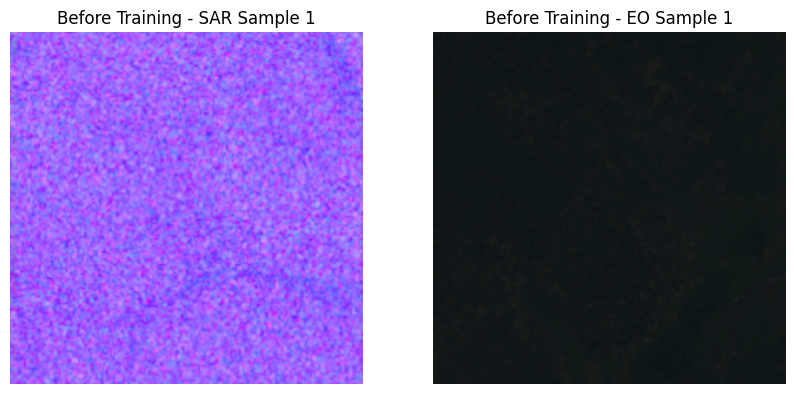

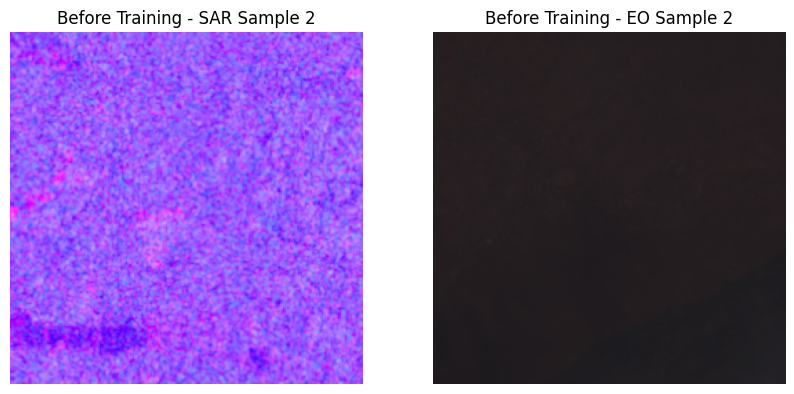

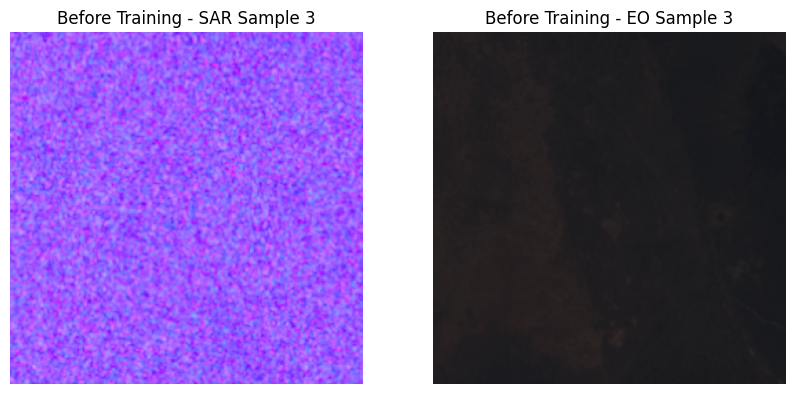

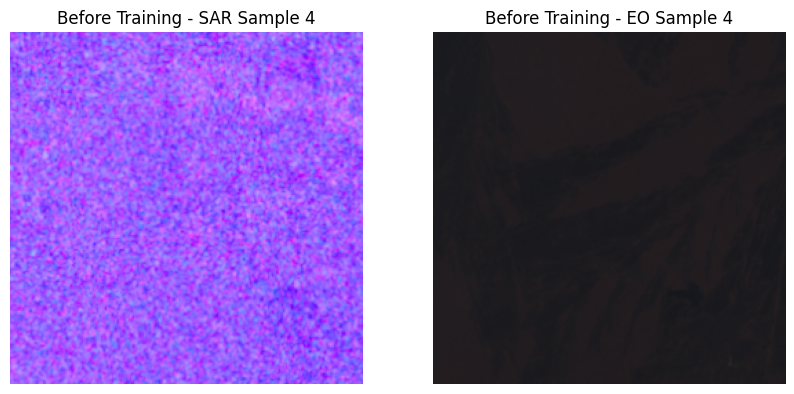

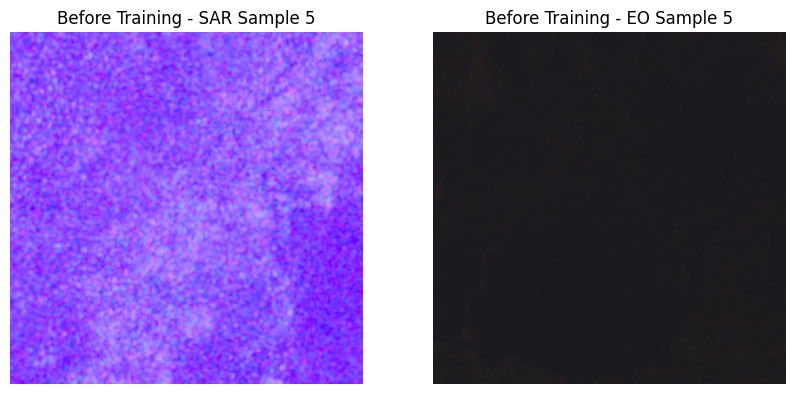

-----------------------------------
Using device: cpu
Current EO Output Configuration: RGB (Bands: [4, 3, 2])
Input Channels (SAR): 3
Output Channels (EO): 3


Checking EO readability: 100%|██████████| 1167/1167 [00:08<00:00, 133.78it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Found 1164 matched SAR-EO pairs.
No checkpoints found, starting training from scratch.
Starting Training Loop...


Epoch 10/200:   0%|          | 1/1164 [00:35<11:25:37, 35.37s/it]

Epoch [10/200], Step [0/1164]
Loss_G: 22.3105 | Loss_G_GAN_A: 0.8911 | Loss_G_GAN_B: 1.7199
Loss_cycle_SAR: 4.9964 | Loss_cycle_EO: 8.1128
Loss_identity_A: 4.0921 | Loss_identity_B: 2.4981
Loss_D_A: 0.5833 | Loss_D_B: 0.9517


Epoch 10/200:   1%|          | 11/1164 [05:55<10:13:04, 31.90s/it]

Epoch [10/200], Step [10/1164]
Loss_G: 5.4078 | Loss_G_GAN_A: 0.5811 | Loss_G_GAN_B: 0.4682
Loss_cycle_SAR: 1.7359 | Loss_cycle_EO: 1.1917
Loss_identity_A: 0.5718 | Loss_identity_B: 0.8591
Loss_D_A: 0.1005 | Loss_D_B: 0.2709


Epoch 10/200:   2%|▏         | 21/1164 [11:17<10:13:28, 32.20s/it]

Epoch [10/200], Step [20/1164]
Loss_G: 4.5781 | Loss_G_GAN_A: 0.4690 | Loss_G_GAN_B: 0.3617
Loss_cycle_SAR: 1.4593 | Loss_cycle_EO: 1.0854
Loss_identity_A: 0.4911 | Loss_identity_B: 0.7115
Loss_D_A: 0.2307 | Loss_D_B: 0.2187


Epoch 10/200:   3%|▎         | 31/1164 [16:41<10:10:13, 32.32s/it]

Epoch [10/200], Step [30/1164]
Loss_G: 6.2662 | Loss_G_GAN_A: 0.5955 | Loss_G_GAN_B: 0.9371
Loss_cycle_SAR: 1.7750 | Loss_cycle_EO: 1.3895
Loss_identity_A: 0.6993 | Loss_identity_B: 0.8697
Loss_D_A: 0.1710 | Loss_D_B: 0.4649


Epoch 10/200:   4%|▎         | 41/1164 [22:03<10:03:23, 32.24s/it]

Epoch [10/200], Step [40/1164]
Loss_G: 3.9867 | Loss_G_GAN_A: 0.3407 | Loss_G_GAN_B: 0.6811
Loss_cycle_SAR: 1.6734 | Loss_cycle_EO: 0.3901
Loss_identity_A: 0.2230 | Loss_identity_B: 0.6784
Loss_D_A: 0.3083 | Loss_D_B: 0.1803


Epoch 10/200:   4%|▎         | 42/1164 [22:37<10:08:05, 32.52s/it]

In [ ]:
if __name__ == '__main__':
    # --- Display Sample Images Before Training ---
    print("\n--- Sample Images Before Training ---")
    # Temporarily create a dataset instance to get raw samples
    temp_dataset = Sen12MSDataset(
        root_dir=config.DATA_ROOT_DIR,
        sar_dir_name=config.SAR_DIR_NAME,
        eo_dir_name=config.EO_DIR_NAME,
        eo_bands=config.EO_BAND_CONFIGS["RGB"], # Use RGB for display
        image_size=config.IMAGE_SIZE
    )
    temp_dataloader = DataLoader(temp_dataset, batch_size=1, shuffle=True, num_workers=0) # Use 0 workers for simple display

    num_before_samples = 5
    sample_count = 0
    for sar_img, eo_img in temp_dataloader:
        if sample_count >= num_before_samples:
            break

        # Denormalize to [0,1] for display
        sar_display = denormalize_image(sar_img.squeeze(0)).cpu().numpy()
        eo_display = denormalize_image(eo_img.squeeze(0)).cpu().numpy()

        # Handle SAR channels for display (2-channel to 3-channel grayscale)
        if sar_display.shape[0] == 2:
            sar_display = sar_display.mean(axis=0, keepdims=True) # Average to 1 channel
            sar_display = np.repeat(sar_display, 3, axis=0) # Repeat to 3 channels
        elif sar_display.shape[0] == 1:
            sar_display = np.repeat(sar_display, 3, axis=0) # Repeat 1 channel to 3

        # Transpose from (C, H, W) to (H, W, C) for matplotlib
        sar_display = np.transpose(sar_display, (1, 2, 0))
        eo_display = np.transpose(eo_display, (1, 2, 0))

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(sar_display)
        plt.title(f"Before Training - SAR Sample {sample_count+1}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(eo_display)
        plt.title(f"Before Training - EO Sample {sample_count+1}")
        plt.axis('off')
        plt.show()
        sample_count += 1
    print("-----------------------------------")


    train_cyclegan()

    # --- Display Sample Images After Training ---
    print("\n--- Sample Images After Training ---")
    output_images_dir = config.OUTPUT_DIR # Images are saved here in Google Drive

    # Get list of saved combined images from the last epoch
    # We need to find the last epoch that saved images
    last_epoch_saved = (config.NUM_EPOCHS // config.SAVE_EPOCH_FREQ) * config.SAVE_EPOCH_FREQ
    if last_epoch_saved == 0 and config.NUM_EPOCHS > 0: # Handle case where NUM_EPOCHS < SAVE_EPOCH_FREQ
        last_epoch_saved = config.NUM_EPOCHS

    if last_epoch_saved == 0: # If no epochs ran or no images saved
        print("No images saved to display. Run more epochs or check SAVE_EPOCH_FREQ.")
    else:
        for i in range(1, 6): # Display 5 samples
            image_path = os.path.join(output_images_dir, f"epoch_{last_epoch_saved}_sample_{i}_combined_SAR_GenEO_RealEO.png")
            if os.path.exists(image_path):
                print(f"Displaying: {os.path.basename(image_path)}")
                display(DisplayImage(filename=image_path))
            else:
                print(f"Image not found: {os.path.basename(image_path)}")
    print("------------------------------------")